In [37]:
import random
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon, Point, LineString, MultiLineString

# Prototype for recursive squares

In [254]:
class Tiler:
    
    max_dim = None 
    
    def __init__ (self, origin, dim, parent=None):
        self.origin = origin
        self.dim = dim
        self.parent = parent
        self.children = []
        if self.level == 0:
            Tiler.max_dim = self.dim

    def __str__(self):
        s = '{}{} x {}\n'.format (' ' * (2 * self.level), self.dim, self.dim)
        for child in self.children: 
            s += str (child)
        return s
    
    def vertices(self, dim):
        
        top_left = self.origin[0], self.origin[1] + dim
        top_right = self.origin[0] + dim, self.origin[1] + dim
        bottom_right = self.origin[0] + dim, self.origin[1]
        
        return (self.origin, top_left, top_right, bottom_right)
        
    def split(self):
            
        if self.children: 
            raise Exception ('Already split')
        
        # split the axis
        half_dim = self.dim/2.
        
        # calculate new origins for sub-squares
        new_origins = self.vertices(half_dim)
        
        # create new tiles as children of current
        self.children = [Tiler(x0y0, half_dim, self) for x0y0 in new_origins]
        
        return self
        
    @property
    def level(self):
        return 0 if not self.parent else 1 + self.parent.level
    
    def splitUntilLevel(self, maxLevel):
        if maxLevel <= self.level: 
            return self
        self.split()
        for child in self.children: 
            child.splitUntilLevel(maxLevel)
        return self
    
    @property
    def lvldim(self):
        return Tiler.max_dim if not self.parent else self.parent.lvldim/2
            
    def splitUntilDim(self, minDim):
        if minDim >= self.lvldim: 
            return self
        self.split()
        for child in self.children: 
            child.splitUntilDim(minDim)
        return self
    
    def yield_tiles(self):
        
        if self.is_leaf():
            yield (self.origin, self.dim)
        else:
            for child in self.children:
                for tile in child.yield_tiles():
                    yield tile
    
    def is_leaf(self):
        return not self.children        

## Testing

In [204]:
mytiles = Tiler((0,0), 20).splitUntilDim(2.025)

for i, x in enumerate(mytiles.yield_tiles()):
    if i < 10:
        print(x)

print("\nLength: {}".format(len(test)))

((0, 0), 1.25)
((0, 1.25), 1.25)
((1.25, 1.25), 1.25)
((1.25, 0), 1.25)
((0, 2.5), 1.25)
((0, 3.75), 1.25)
((1.25, 3.75), 1.25)
((1.25, 2.5), 1.25)
((2.5, 2.5), 1.25)
((2.5, 3.75), 1.25)

Length: 200


## Try to implement with a grid

In [209]:
tile_size = 10 

x_dim = np.arange(0, 200, tile_size)
y_dim = np.arange(0, 100, tile_size)

x_grid, y_grid = np.meshgrid(x_dim, y_dim)

In [210]:
coords = np.vstack((x_grid.ravel(), y_grid.ravel())).T

In [211]:
def grid_points(origin, dim):

    top_left = origin[0], origin[1] + dim
    top_right = origin[0] + dim, origin[1] + dim
    bottom_right = origin[0] + dim, origin[1]

    return Polygon([tuple(origin), top_left, top_right, bottom_right])

In [272]:
grid_verts = [(tuple(xy), tile_size) for xy in coords]
grid_verts[:2]

[((0, 0), 10), ((10, 0), 10)]

In [273]:
# geometries to tile on
circle = Point((100, 40)).buffer(20)

line = LineString([(50, 10), (150, 80)])

In [297]:
def tile_square(verts, poly, min_size):
    
    
    if verts[-1] > min_size:
        
        tile = Polygon(grid_points(*verts))
        overlap = tile.intersection(poly)
        if (overlap.area > 0.2*tile.area) and (overlap.area < 0.9*tile.area):
            print(verts)
        bounds = tile.bounds
        x0y0 = bounds[:2]
        xylen = bounds[2] - bounds[0]
        
        if overlap.area > 0.9*tile.area:

            block = Tiler(x0y0, xylen).splitUntilDim(min_size)
            new_tiles = block.yield_tiles()
            return list(new_tiles)

        else:
            if (overlap.area > 0.2*tile.area): # and (overlap.area < 0.9*tile.area):
                
                new_block = Tiler(x0y0, xylen).split().yield_tiles()
                for mtile in new_block:
                    print(mtile)
                    tile_square(mtile, poly, min_size)
                print("")
                return "Bug"
            else:

                return verts
    else:
        return verts
    

test = [tile_square(grid, circle, 1.25) for grid in grid_verts]

((80, 20), 10)
((80.0, 20.0), 5.0)
((80.0, 25.0), 5.0)
((85.0, 25.0), 5.0)
((85.0, 20.0), 5.0)

((110, 20), 10)
((110.0, 20.0), 5.0)
((110.0, 25.0), 5.0)
((115.0, 25.0), 5.0)
((115.0, 20.0), 5.0)

((80, 50), 10)
((80.0, 50.0), 5.0)
((80.0, 55.0), 5.0)
((85.0, 55.0), 5.0)
((85.0, 50.0), 5.0)

((110, 50), 10)
((110.0, 50.0), 5.0)
((110.0, 55.0), 5.0)
((115.0, 55.0), 5.0)
((115.0, 50.0), 5.0)



In [298]:
test

[((0, 0), 10),
 ((10, 0), 10),
 ((20, 0), 10),
 ((30, 0), 10),
 ((40, 0), 10),
 ((50, 0), 10),
 ((60, 0), 10),
 ((70, 0), 10),
 ((80, 0), 10),
 ((90, 0), 10),
 ((100, 0), 10),
 ((110, 0), 10),
 ((120, 0), 10),
 ((130, 0), 10),
 ((140, 0), 10),
 ((150, 0), 10),
 ((160, 0), 10),
 ((170, 0), 10),
 ((180, 0), 10),
 ((190, 0), 10),
 ((0, 10), 10),
 ((10, 10), 10),
 ((20, 10), 10),
 ((30, 10), 10),
 ((40, 10), 10),
 ((50, 10), 10),
 ((60, 10), 10),
 ((70, 10), 10),
 ((80, 10), 10),
 ((90, 10), 10),
 ((100, 10), 10),
 ((110, 10), 10),
 ((120, 10), 10),
 ((130, 10), 10),
 ((140, 10), 10),
 ((150, 10), 10),
 ((160, 10), 10),
 ((170, 10), 10),
 ((180, 10), 10),
 ((190, 10), 10),
 ((0, 20), 10),
 ((10, 20), 10),
 ((20, 20), 10),
 ((30, 20), 10),
 ((40, 20), 10),
 ((50, 20), 10),
 ((60, 20), 10),
 ((70, 20), 10),
 'Bug',
 [((90.0, 20.0), 1.25),
  ((90.0, 21.25), 1.25),
  ((91.25, 21.25), 1.25),
  ((91.25, 20.0), 1.25),
  ((90.0, 22.5), 1.25),
  ((90.0, 23.75), 1.25),
  ((91.25, 23.75), 1.25),
  ((

In [244]:
temp = [item for sublist in test if sublist for item in sublist]

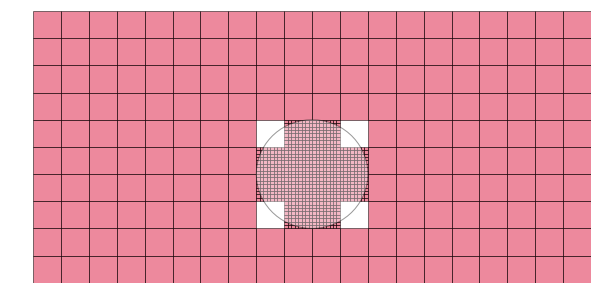

In [245]:
plt.figure(figsize=(10, 5))

ax = plt.subplot(111)
for verts in temp:
    p = PolygonPatch(verts, fc='crimson', ec='black', alpha=0.5)
    ax.add_patch(p)
ax.add_patch(PolygonPatch(circle, fc='white', alpha=0.4))
#ax.plot(line.xy[0], line.xy[1], '-', lw=2, c='white')
    
ax.set_xlim(0, 200)
ax.set_ylim(0, 100)
ax.axis('off')
    
plt.show()